In [1]:
#!/usr/bin/env python
# coding: utf-8

# In[1]:


#!/usr/bin/env python
# coding: utf-8

# In[1]:


from tqdm import tqdm
import numpy as np
import pandas as pd
import anndata
from anndata import read_h5ad
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
import torch
import random
import torch.nn as nn
import torch.utils.data as data
import torch.nn.functional as F
from torch.autograd import Variable
import matplotlib.pyplot as plt

# In[2]:


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# In[3]:


def preprocess(trainingdatapath, testx=None, testy=None, testlabel='seq'):
    if (testx is not None) and (testy is not None):
        pbmc = read_h5ad(trainingdatapath)
        donorA = pbmc[pbmc.obs['ds']=='donorA']
        donorC = pbmc[pbmc.obs['ds']=='donorC']
        data6k = pbmc[pbmc.obs['ds']=='data6k']
        data8k = pbmc[pbmc.obs['ds']=='data8k']
        train_data = anndata.concat([donorA,donorC,data6k,data8k])
        test_x = pd.read_csv(testx, sep='\t')
        test_y = pd.read_excel(testy)
        intersection_genes = list(test_x.index.intersection(train_data.var.index))
        test_x = test_x.loc[intersection_genes]
        simuvar = list(train_data.var.index)
        intersection_gene_position = []
        for gene in intersection_genes:
            intersection_gene_position.append(simuvar.index(gene))
        selected = np.zeros((len(intersection_genes), len(train_data.X)))
        for i in range(selected.shape[0]):
            selected[i] = train_data.X.T[intersection_gene_position[i]]
        train_x = selected.T
        intersection_cell = list(test_y.columns.intersection(train_data.obs.columns))
        train_y = train_data.obs[intersection_cell].values
        ### re
        for i, values in enumerate(train_y):
            r_sum = np.sum(values)
            if r_sum == 0:
                pass
            else:
                train_y[i] = train_y[i] / r_sum
        ###
        test_y = test_y[intersection_cell]
        test_x = test_x.T
        test_x = test_x.values
        test_y = test_y.values
        ### re
        for i, values in enumerate(test_y):
            r_sum = np.sum(values)
            if r_sum == 0:
                pass
            else:
                test_y[i] = test_y[i] / r_sum
        ###
        assert test_x.shape[1] == train_x.shape[1]
        assert test_y.shape[1] == train_y.shape[1]
        return train_x, train_y, test_x, test_y
    
    else:
        pbmc = read_h5ad(trainingdatapath)
            
        pbmc1 = pbmc[pbmc.obs['ds']=='sdy67']
        microarray = pbmc[pbmc.obs['ds']=='GSE65133']
            
        donorA = pbmc[pbmc.obs['ds']=='donorA']
        donorC = pbmc[pbmc.obs['ds']=='donorC']
        data6k = pbmc[pbmc.obs['ds']=='data6k']
        data8k = pbmc[pbmc.obs['ds']=='data8k']
            
        if testlabel == 'seq':
            test = pbmc1
            train = anndata.concat([donorA, donorC, data6k, data8k])
            #train = anndata.concat([donorA, donorC, data6k])
        elif testlabel == 'microarray':
            test = microarray
            train = anndata.concat([donorA,donorC,data6k,data8k,pbmc1])
            #train = anndata.concat([donorA,data8k,pbmc1])
                
        train_y = train.obs.iloc[:,:-2].values
        test_y = test.obs.iloc[:,:-2].values
        
        #### variance cut off
        if testlabel == 'seq':
            label = test.X.var(axis=0) > 0.1
        elif testlabel == 'microarray':
            label = test.X.var(axis=0) > 0.01
        test_x_new = np.zeros((test.X.shape[0],np.sum(label)))
        train_x_new = np.zeros((train.X.shape[0],np.sum(label)))
        k = 0
        for i in range(len(label)):
            if label[i] == True:
                test_x_new[:,k] = test.X[:,i]
                train_x_new[:,k] = train.X[:,i]
                k += 1
        ####
        return train_x_new, train_y, test_x_new, test_y


# In[2]:


class simdatset(data.Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        x = torch.from_numpy(self.X[index]).float().to(device)
        y = torch.from_numpy(self.Y[index]).float().to(device)
        return x, y


class AutoEncoder(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.name = 'ae'
        self.inputdim = input_dim
        self.outputdim = output_dim
        self.encoder = nn.Sequential(nn.Linear(self.inputdim,100,bias=True),
                                     nn.LayerNorm(100),
                                     nn.CELU(),
                                     nn.Linear(100,100,bias=True),
                                     nn.LayerNorm(100),
                                     nn.CELU(),
                                     nn.Linear(100,self.outputdim,bias=True))
                                     #nn.Softmax(dim=1))
        self.decoder = nn.Sequential(nn.Linear(self.outputdim,100,bias=False),
                                     nn.Linear(100,100,bias=False),
                                     nn.Linear(100, self.inputdim,bias=False))
        
    def forward(self, x):
        code = self.encoder(x)
        code_nograd = code.detach()
        x_recon = self.decoder(code_nograd)
        return code, x_recon

class MLP(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.name = 'mlp'
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.model = self._mlp()

    def forward(self,x):
        # x: (n sample, m gene)
        # output: (n sample, k cell proportions)
        return self.model(x)

    def _mlp(self):
        mlp = nn.Sequential(nn.Linear(self.input_dim,512),
                            nn.Dropout(0),
                            nn.ReLU(),
                            nn.Linear(512, 256),
                            nn.Dropout(0.3),
                            nn.ReLU(),
                            nn.Linear(256, 128),
                            nn.Dropout(0.2),
                            nn.ReLU(),
                            nn.Linear(128, 64),
                            nn.Dropout(0),
                            nn.ReLU(),
                            nn.Linear(64, self.output_dim),
                            nn.Softmax(dim=1))
        return mlp



def train(model, loader, optimizer, epochs=10):
    model.train()
    loss = []
    recon_loss = []
    for i in tqdm(range(epochs)):
        for data, label in loader:
            optimizer.zero_grad()
            if model.name == 'mlp':
                code = model(data)
                batch_loss = F.l1_loss(code,label)
            elif model.name == 'ae':
                code, x_recon = model(data)
                batch_loss = F.l1_loss(code,label)+F.l1_loss(x_recon,data)
                recon_loss.append(F.l1_loss(x_recon,data).cpu().detach().numpy())
            batch_loss.backward()
            optimizer.step()
            
            loss.append(batch_loss.cpu().detach().numpy())
    if model.name == 'mlp':
        return model, loss
    elif model.name=='ae':
        return model, loss, recon_loss

def RMSEscore(pred, true):
    return np.sqrt(np.mean(np.square(pred - true)))


def CCCscore(y_pred, y_true):
    # pred: shape{n sample, m cell}
    ccc_value = 0
    for i in range(y_pred.shape[1]):
        r = np.corrcoef(y_pred[:, i], y_true[:, i])[0, 1]
        # print(r)
        # Mean
        mean_true = np.mean(y_true[:, i])
        mean_pred = np.mean(y_pred[:, i])
        # Variance
        var_true = np.var(y_true[:, i])
        var_pred = np.var(y_pred[:, i])
        # Standard deviation
        sd_true = np.std(y_true[:, i])
        sd_pred = np.std(y_pred[:, i])
        # Calculate CCC
        numerator = 2 * r * sd_true * sd_pred
        denominator = var_true + var_pred + (mean_true - mean_pred) ** 2
        ccc = numerator / denominator
        # print(ccc)
        ccc_value += ccc
    return ccc_value / y_pred.shape[1]

def score(model, loader):
    model.eval()
    CCC = 0
    RMSE = 0
    for data, label in loader:
        if model.name=='ae':
            pred, _ = model(data)
        elif model.name == 'mlp':
            pred = model(data)
        RMSE += RMSEscore(pred.cpu().detach().numpy(), label.cpu().detach().numpy())
        new_pred = pred.reshape(pred.shape[0]*pred.shape[1],1)
        new_label = label.reshape(label.shape[0]*label.shape[1],1)
        CCC += CCCscore(new_pred.cpu().detach().numpy(), new_label.cpu().detach().numpy())
    return CCC / len(loader), RMSE / len(loader), pred.cpu().detach().numpy()

def showloss(loss):
    plt.figure()
    plt.plot(loss)
    plt.xlabel('iteration')
    plt.ylabel('loss')
    #plt.title()
    #plt.savefig(str(z)+'_'+str(beta)+'_'+str(gamma)+'.png')
    plt.show()


# In[9]:


def search(train_x,train_y,test_x,test_y):
    train_loader = data.DataLoader(simdatset(train_x, train_y), batch_size=128, shuffle=True)
    test_loader = data.DataLoader(simdatset(test_x, test_y), batch_size=len(test_x), shuffle=False)
    model = AutoEncoder(train_x.shape[1],train_y.shape[1]).to(device)
    #model = MLP(train_x.shape[1],train_y.shape[1]).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    if model.name == 'ae':
        model, loss, recon_loss = train(model, train_loader, optimizer,epochs=5)
        showloss(loss)
        showloss(recon_loss)
    elif model.name == 'mlp':
        model, loss = train(model, train_loader, optimizer,epochs=10)
        showloss(loss)
    ccc, rmse, pred = score(model, test_loader)
    print(ccc, rmse)





def reproducibility(seed=1):
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True



In [2]:
train_x, train_y, test_x, test_y = preprocess('pbmc_data.h5ad')
train_x = np.log2(train_x + 1)
test_x = np.log2(test_x + 1)
mms = MinMaxScaler()
test_x = mms.fit_transform(test_x.T)
test_x = test_x.T
train_x = mms.fit_transform(train_x.T)
train_x = train_x.T

print('train_x shape',train_x.shape)
print('train_y shape',train_y.shape)
print('test_x shape',test_x.shape)
print('test_y shape',test_y.shape)

# In[5]:

# train_dict = np.random.rand(6, 10134)
# train_y = np.random.rand(32000, 6)
# train_x = np.dot(train_y,train_dict)


# lr = LinearRegression(fit_intercept=False,positive=True,n_jobs=-1) 
# lr.fit(train_x,train_y)
# dictlearn = (lr.coef_).T 
# print(dictlearn.shape)


# In[4]:




train_x shape (32000, 10134)
train_y shape (32000, 6)
test_x shape (12, 10134)
test_y shape (12, 6)


100%|██████████| 5/5 [00:15<00:00,  3.17s/it]


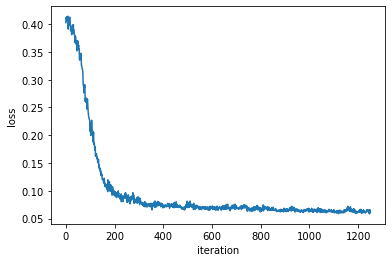

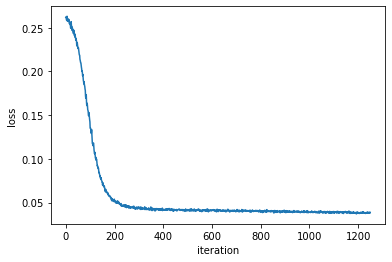

0.6091314270833637 0.10205836594104767


In [9]:
reproducibility(seed=3)
search(train_x,train_y,test_x,test_y)

In [4]:
# train_x, train_y, test_x, test_y = preprocess('pbmc_data.h5ad','TPMPBMC.txt','PBMC2.xlsx')
# train_x = np.log2(train_x + 1)
# test_x = np.log2(test_x + 1)
# mms = MinMaxScaler()
# test_x = mms.fit_transform(test_x.T)
# test_x = test_x.T
# train_x = mms.fit_transform(train_x.T)
# train_x = train_x.T

# print('train_x shape',train_x.shape)
# print('train_y shape',train_y.shape)
# print('test_x shape',test_x.shape)
# print('test_y shape',test_y.shape)

# # lr = LinearRegression(fit_intercept=False,positive=True,n_jobs=-1) 
# # lr.fit(train_x,train_y)
# # dictlearn = (lr.coef_).T 
# # print(dictlearn.shape)

In [5]:
# reproducibility(seed=2)
# search(train_x,train_y,test_x,test_y)